# Signal Conversion Lab1 - Sar ADC

## General Functions

In [48]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt  

#import datetime

TYPE = np.float64

def num2bin(n,n_bits):
    
    tmp = [ int(i) for i in bin(n)[2:] ]
    if len(tmp) < n_bits:
        code = np.append( [ int(0) for _ in range( int(n_bits) - len(tmp)  ) ],tmp  )
    else:
        code = np.asarray(tmp,dtype=int)
    
    return np.flip(code)


## DAC

$$V_x = V_{i}  + V_{ref}\frac{ \sigma_{MB}\cdot(C_B+\sigma_{LC})+\sigma_{LB}\cdot C_B  - \sigma_{Cb}\cdot\sigma_{LC}}{C_{B} ( \sigma_{LC} + \sigma_{MC}) + \sigma_{LC} \sigma_{MC}}$$


$~$
Where:

$\displaystyle \sigma_{LC} = C_{0'} + \sum_{i=0}^{\text{bits LSB}}C_i$

$\displaystyle \sigma_{MC} = C_{M0} + \sum_{i=0}^{\text{bits MSB}}(C_{ai}+C_{bi})$

$\displaystyle \sigma_{LB} = \sum_{i=0}^{\text{bits LSB}}C_i\cdot b_i$

$\displaystyle \sigma_{MB} = C_{M0}\cdot b_{M0} + \sum_{i=0}^{\text{bits MSB}}b_i\cdot(C_{ai}+C_{bi})$

In [49]:
def dac_TF(C_ai, C_bi,C_M0, C_Li,C_B,C_B0l,vi,vr,code_matrix = 0,n_bits = -1):

    C_abi = C_ai + C_bi
    s_LC = sum( C_Li ) + C_B0l 
    s_MC = sum( C_abi) + C_M0
    s_Cb = sum( C_bi )*s_LC

    if n_bits == -1:
        n_bits = len(C_ai) + len(C_Li) + 1

    if( code_matrix == 0 ):
        code_matrix  = [ num2bin(i,n_bits) for i in range(0,2**n_bits) ] 
    
    g  = 1/( C_B*( s_LC + s_MC ) + s_LC*s_MC )
    
    tf = np.empty(shape=(2**n_bits),dtype=TYPE)
    for j in range(0,2**n_bits ):

        code    = code_matrix[j]
        Lsb_qty = len(C_Li)
        s_LB    = 0 
        s_MB    = code[Lsb_qty]*C_M0

        for i in range( 0, Lsb_qty):
            s_LB += C_Li[i]*code[i]

        for i in range( 0, len(C_abi)):
            s_MB += C_abi[i]*code[i+Lsb_qty+1]

        tf[j] = vi + vr*g*( (C_B+s_LC)*s_MB +  s_LB*C_B - s_Cb)
    return tf



def get_Vlsb_real( dac_tf ):
    
    dac_len = len(dac_tf) - 1
    return ( dac_tf[ dac_len  ] - dac_tf[0] ) / dac_len 

def get_INL(dac_tf, Vlsb_real):

    dac_len = len(dac_tf)
    return (dac_tf - np.arange(dac_len) * Vlsb_real - dac_tf[0]) / Vlsb_real

def get_DNL(dac_tf, Vlsb_real):

    return ((dac_tf[1:] - dac_tf[:-1]) / Vlsb_real) - 1


### Dac Test

0.031249999999999997


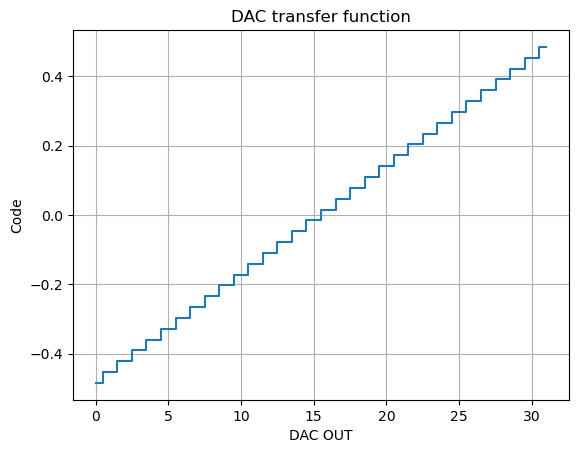

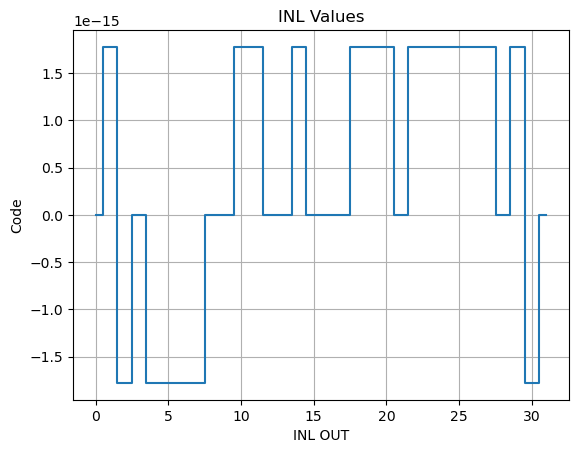

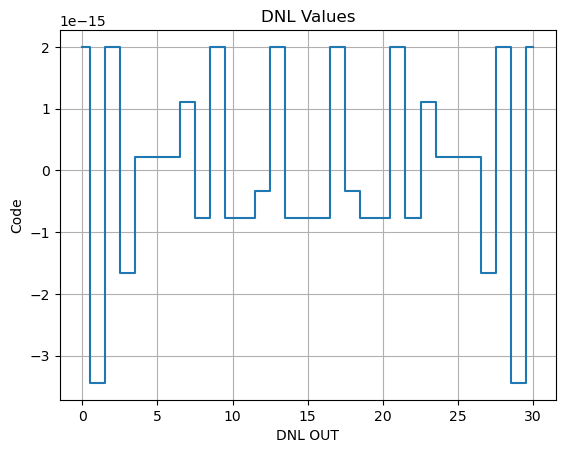

In [50]:


n_bits = 4
C_ai   = np.asarray([ 2**(i-1) for i in range(1,int(n_bits/2) + 1) ])
C_bi   = np.asarray([ 2**(i-1) for i in range(1,int(n_bits/2) + 1) ])
C_Li   = np.asarray([ 2**i for i in range(0,int(n_bits/2)) ])
C_M0   = 1 
C_B    = (2**(len(C_Li)))/( (2**(len(C_Li))) - 1 )
C_B0l  = 1
vr     = 0.5
vi     = 0


n_bits    = len(C_ai) + len(C_Li) + 1
codes     = [ num2bin(i,n_bits) for i in range(0,2**n_bits) ]# Avoids recalculating all codes for all monte carlo iterations
neg_codes = [ (code - 1)*(-1) for code in codes ]
#start = datetime.datetime.now()

Vx_p = dac_TF(
            C_ai,
            C_bi,
            C_M0, 
            C_Li,
            C_B,
            C_B0l,
            vi,
            vr,
            code_matrix = codes,
            n_bits = n_bits)
Vx_n = dac_TF(
            C_ai,
            C_bi,
            C_M0, 
            C_Li,
            C_B,
            C_B0l,
            vi,
            vr,
            code_matrix = neg_codes,
            n_bits = n_bits)

res_dac = Vx_p - Vx_n
x = [ n for n in range(0,2**n_bits) ]
#print("dac_Transfer_function time = "+ str( (datetime.datetime.now() - start).total_seconds() ) )

Vlsb_real = get_Vlsb_real(res_dac)
print(Vlsb_real)
inl_res = get_INL(res_dac, Vlsb_real)

dnl_res = get_DNL(res_dac, Vlsb_real)

plt.step(x, res_dac,where='mid')
#plt.plot(x, res_dac, 'o', color='orange')
plt.xlabel("DAC OUT")
plt.ylabel("Code")
plt.title("DAC transfer function")
#  plt.legend()
plt.grid(True)
plt.show()

plt.step(x, inl_res,where='mid')
#plt.plot(x, res_dac, 'o', color='orange')
plt.xlabel("INL OUT")
plt.ylabel("Code")
plt.title("INL Values")
plt.grid(True)
plt.show()

plt.step(x[:-1], dnl_res,where='mid')
#plt.plot(x, res_dac, 'o', color='orange')
plt.xlabel("DNL OUT")
plt.ylabel("Code")
plt.title("DNL Values")
plt.grid(True)
plt.show()

## ADC

In [51]:

#n_bits = 12
code_vec = np.asarray([ 2**i for i in range( 0,n_bits+1 ) ])
#n = 69
#n = num2bin(n,12)
#print(n)
#print( sum(n*code_vec) )
def code2num(code) -> int:
    #print(code)
    return np.sum(code*code_vec[:-1])

def code2num2(code) -> int:
    #print(code)
    return np.sum(code*code_vec)

def adc(vin,dac_TF,n_bits) -> list[int]:

    code = num2bin(0,n_bits)#np.zeros(n_bits,dtype=int)
    for i in range(n_bits-1,-1,-1):
        #code_aux = code.copy()
        code[i]  = 1    
        pos  = code2num(code)
        vout = dac_TF[pos]
        if vin < vout :
            code[i] = 0 

    return code


def adc2(vin,dac_TF,n_bits) -> list[int]:
    
    code = np.zeros(n_bits + 1,dtype=int)
    code_aux = np.zeros(n_bits + 1,dtype=int)

    code[n_bits] = int(vin > 0) 
    code_aux[n_bits] = int(vin > 0) 
    
    for i in range(n_bits - 1,-1,-1):
        
        vout = dac_TF[2**i]#dac_TF[code2num(code[-1:])]
        vin += vout

        if vin > 0:
            code[i] = 1

        print(code,end=' ')
        print( code2num2(code) )
        print(vout)
        print(vin)
    return code

print(code2num2(adc2(0.2,res_dac,n_bits)))
print(code2num(adc(0.2,res_dac,n_bits)))

[0 0 0 0 1 1] 48
0.015624999999999986
0.215625
[0 0 0 0 1 1] 48
-0.23437499999999997
-0.01874999999999996
[0 0 0 0 1 1] 48
-0.359375
-0.37812499999999993
[0 0 0 0 1 1] 48
-0.421875
-0.7999999999999999
[0 0 0 0 1 1] 48
-0.4531249999999999
-1.2531249999999998
48
21


### ADC Test

[0 0 0 0 0 0] 0
0.015624999999999986
-0.984375
[0 0 0 0 0 0] 0
-0.23437499999999997
-1.21875
[0 0 0 0 0 0] 0
-0.359375
-1.578125
[0 0 0 0 0 0] 0
-0.421875
-2.0
[0 0 0 0 0 0] 0
-0.4531249999999999
-2.453125
[0 0 0 0 0 0] 0
0.015624999999999986
-0.984275
[0 0 0 0 0 0] 0
-0.23437499999999997
-1.21865
[0 0 0 0 0 0] 0
-0.359375
-1.578025
[0 0 0 0 0 0] 0
-0.421875
-1.9999
[0 0 0 0 0 0] 0
-0.4531249999999999
-2.453025
[0 0 0 0 0 0] 0
0.015624999999999986
-0.984175
[0 0 0 0 0 0] 0
-0.23437499999999997
-1.21855
[0 0 0 0 0 0] 0
-0.359375
-1.577925
[0 0 0 0 0 0] 0
-0.421875
-1.9998
[0 0 0 0 0 0] 0
-0.4531249999999999
-2.452925
[0 0 0 0 0 0] 0
0.015624999999999986
-0.984075
[0 0 0 0 0 0] 0
-0.23437499999999997
-1.21845
[0 0 0 0 0 0] 0
-0.359375
-1.577825
[0 0 0 0 0 0] 0
-0.421875
-1.9997
[0 0 0 0 0 0] 0
-0.4531249999999999
-2.452825
[0 0 0 0 0 0] 0
0.015624999999999986
-0.983975
[0 0 0 0 0 0] 0
-0.23437499999999997
-1.21835
[0 0 0 0 0 0] 0
-0.359375
-1.577725
[0 0 0 0 0 0] 0
-0.421875
-1.9996
[0 0

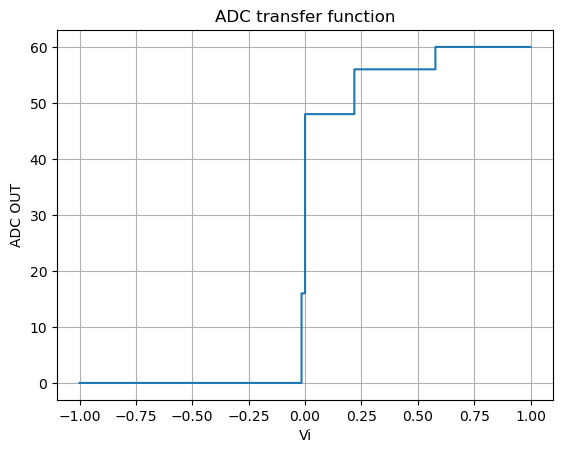

In [52]:

x =[ x/(10**4) for x in range( -10**4,10**4 ) ] 
res_adc  = np.empty(len(x),dtype=int)
res_adc2 = np.empty(len(x),dtype=int)

i = 0
for n in x:
    res_adc[i] = code2num( adc(n,res_dac,n_bits) )
    res_adc2[i] = code2num2( adc2(n,res_dac,n_bits) )    
    i += 1

#res_adc = [ code2num( adc( i ,res_dac,n_bits) for i in x ) ]

#plt.step(x,res_adc,where='mid')
plt.step(x,res_adc2,where='mid')
#plt.plot(x, res_adc, 'o', color='orange')
plt.ylabel("ADC OUT")
plt.xlabel("Vi")
plt.title("ADC transfer function")
#  plt.legend()
plt.grid(True)
plt.show()